# DIVAnd Full CARS Example

Here we illustrate reading WOD, AIMS and MNF profile data, then using DIVAnd to perform a 3d mapping. The Great Barrier Reef region is used as an example in order to show the utility of including "boutique" data from AIMS/MNF

In [5]:
using NCDatasets
using PhysOcean
using DataStructures
using DIVAnd
using Dates
using Statistics
using Random
using Printf
using PyPlot
#using Iterators

In [6]:
function CSIRO_standard_levels()
    
    """
    CSIRO_standard_levels()

    Simple list to return the pre-defined CSIRO standard levels

    # Examples
    ```julia-repl
    julia> CSIRO_standard_levels()
    """
    
    depth_levels  = Array{Float32}([2,5,10,20,30,40,50,60,70,75,80,90,100,110,120,125,130,140,150,160,170,175,180,190,200,
                               210,220,225,230,240,250,260,270,275,280,290,300,325,350,375,400,425,450,475,500,550,600,
                               650,700,750,800,850,900,950,1000,1100,1200,1300,1400,1500,1600,1700,1750,1800,1900,2000,
                               2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000,5500,6000])
    return depth_levels
end

CSIRO_standard_levels (generic function with 1 method)

## Configuration
* Define the domain limits and horizontal and vertical grids for the mapped fields, as well as the temporal range.
* The example of the Great Barrier Reef region is used for illustrative purposes


In [27]:
#==============GBR===============#

LONGITUDE_LIM_WEST = 142.0
LONGITUDE_LIM_EAST = 155.0

LATITUDE_LIM_SOUTH = -28.0
LATITUDE_LIM_NORTH =  -10.0
#==============GBR===============#


#==============TAS===============#

#LONGITUDE_LIM_WEST = 140
#LONGITUDE_LIM_EAST = 150

#LATITUDE_LIM_SOUTH = -50
#LATITUDE_LIM_NORTH =  -35
##==============GBR===============#
varname = "Temp"

dx = 0.1 # longitude resolution in degrees
dy = 0.1 # latitude resolution in degrees

lonr = Array{Float32}(LONGITUDE_LIM_WEST:dx:LONGITUDE_LIM_EAST); # the range of longitudes (start:step:end)
latr = Array{Float32}(LATITUDE_LIM_SOUTH:dy:LATITUDE_LIM_NORTH); # the range of latitudes (start:step:end)

#timerange = [Date(2018,1,1),Date(2018,12,31)];
depthr = CSIRO_standard_levels();
depthr = depthr[1:15];

#monthlist = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]];

#Perform mapping on individual months
monthlist = [[1],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11],[12]];


#Perform  mapping on individual years
#yearlist = [[2005],[2006],[2007],[2008],[2009],[2010],[2011],[2012],[2013],[2014],[2015],[2016],[2017],[2018],[2019],[2020],[2021],[2022]]

#Perform mapping over all years between 2005 and 2022 (inclusive) ie. Do not generate independent analyses for each year, but a climatology of ALL 
#selected years
yearlist = [2005:2022]

TS = DIVAnd.TimeSelectorYearListMonthList(yearlist,monthlist);
@show TS;

TS = TimeSelectorYearListMonthList{Vector{UnitRange{Int64}}, Vector{Vector{Int64}}}(UnitRange{Int64}[2005:2022], [[1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12]])


## Create a list of individual World Ocean Database files to ingest. 
Here we use the vertically interpolated profiles created by the python notebook Prepare_WOD_input

In [8]:
#Base data path
data_path  = "/tube1/cha674/CARS_2022_ancillary_data/WOD_intermediate/interp_WOD_profiles_GBR/"
#data_path = "/tube1/cha674/CARS_2022_ancillary_data/WOD_intermediate/interp_WOD_profiles_TAS/"

#Variable to read 
data_variable = "Temperature"
#=======================#
#Observational platform: 
# - ctd = CTD cast
# - pfl = profiling float (mostly Argo)
# - xbt = XBT profile
# - gld = ocean glider
# - mrd = moored instrument (mostly tropical moored array)
# - osd = ocean station
#=======================#


#Note that in this example gliders are NOT selected as the high density of profiles
#causes issues. I'm working on it. Appending "gld" to the platform_types list will include them

platform_types = ["ctd","pfl","xbt"] #,"gld"]
WOD_intermediate_file_tail = ".GBR_region.interp_standard_level.nc"
WOD_standard_files = []
start_year = 2005
end_year   = 2022

#Loop through years and platform types to build a list
for i_year in start_year:end_year
    println(i_year)
    for i_platform in platform_types

        WOD_data_full_path = string(data_path,"WOD_",i_year,"_",data_variable,"_",i_platform,WOD_intermediate_file_tail)
        #println(WOD_data_full_path)
        if isfile(WOD_data_full_path)
            #ds = Dataset(WOD_data_full_path)
            push!(WOD_standard_files,WOD_data_full_path)
        end
    end
end

start_time_ordinate  = DateTime("1970-01-01",dateformat"y-m-d")

2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022


1970-01-01T00:00:00

## Get the number of individual casts
Used for pre-allocation of arrays for output data 

In [9]:
depths_to_read =30 
total_casts = 0


for file_index in 1:length(WOD_standard_files)
    WOD_dataset =  Dataset(WOD_standard_files[file_index])
    
    casts = WOD_dataset["casts"]
    n_casts = length(casts)
    
    total_casts = total_casts + n_casts;
    close(WOD_dataset)
end
@show total_casts;

total_casts = 15486


## Read the WOD profiles
* Loop through all individual WOD files (stored by ocean variable, year and platform) 
* vertically interpolated casts are stored in the form (cast,depth). DIVAnd requires ragged array-like structure;
* we read the data in the native (cast,depth) form, then unroll into the long array structure DIVA likes.


In [10]:
depths_to_read=30

#Strongly type pre-allocated arrays to avoid error
longitude   = zeros(Float32, depths_to_read,total_casts)
latitude    = zeros(Float32, depths_to_read,total_casts)
time        = zeros(Int64, depths_to_read,total_casts)   
depth       = zeros(Float32, depths_to_read,total_casts)
temperature = zeros(Float32, depths_to_read,total_casts)

cast_counter = 1
for file_index in 1:length(WOD_standard_files)
    
    #Open the WOD netcdf file    
    WOD_dataset =  Dataset(WOD_standard_files[file_index])
    
    #Get the vertical coordinate (here pressure)
    current_depth =WOD_dataset["pressure"].var[:]
    current_depth = current_depth[1:depths_to_read]
    
    
    current_longitude  =  WOD_dataset["lon"].var[:,:] 
    current_latitude   =  WOD_dataset["lat"].var[:,:] 
    current_time       =  WOD_dataset["time"].var[:,:]
    
   # println(WOD_dataset["time"].attrib["units"])
    
    n_profiles = length(WOD_dataset["casts"])
    
    current_depth = repeat(current_depth,outer=[1,n_profiles])
   
    
    current_longitude = transpose(repeat(current_longitude,outer=[1,depths_to_read]))
    current_latitude  = transpose(repeat(current_latitude,outer=[1,depths_to_read]))
    current_time      = transpose(repeat(current_time,outer=[1,depths_to_read]))
    
    
    current_temperature = WOD_dataset["Temperature"].var[1:depths_to_read,:]
    
    temperature[:,cast_counter:cast_counter+n_profiles-1] = current_temperature #vec(current_temperature)
    depth[:,cast_counter:cast_counter+n_profiles-1]       = current_depth #vec(current_depth)
    longitude[:,cast_counter:cast_counter+n_profiles-1]   = current_longitude
    latitude[:,cast_counter:cast_counter+n_profiles-1]    = current_latitude
    time[:,cast_counter:cast_counter+n_profiles-1]        = current_time
    
    
    cast_counter = cast_counter + n_profiles
    close(WOD_dataset)

end
temperature = vec(temperature)
depth       = vec(depth)
longitude = vec(longitude)
latitude = vec(latitude)
time = vec(time)
    
    

println("Read data")


deleteat!(longitude  , findall(isnan.(temperature)) )
deleteat!(latitude   , findall(isnan.(temperature)) )
deleteat!(time       , findall(isnan.(temperature)) )
deleteat!(depth       , findall(isnan.(temperature)) )

deleteat!(temperature, findall(isnan.(temperature)) )

deleteat!(longitude  , findall((temperature.<=0) .| (temperature.>40)) )
deleteat!(latitude   , findall((temperature.<=0) .| (temperature.>40)) )
deleteat!(time       , findall((temperature.<=0) .| (temperature.>40)) )
deleteat!(depth      , findall((temperature.<=0) .| (temperature.>40)) )

deleteat!(temperature, findall((temperature.<=0) .| (temperature.>40)) )



observation_id = [0:length(longitude):1]
println(size(temperature))

time_dates = start_time_ordinate + Dates.Second.(Int64.(floor.(time*1.0e-9) ));
#longitude = longitude .+ 360;

Read data
(385663,)


## Read the ancillary data from AIMS and MNF. 
Note that these data likely to be of lower quality than the WOD data. 

In [13]:
ancillary_data_path  = "/tube1/cha674/CARS_2022_ancillary_data/WOD_intermediate/"
ancillary_data_files = ["AIMS_TEMP_CTD.GBRN_region.interp_standard_level.nc","AIMS_TEMP_CTD.GBR_region.interp_standard_level.nc",
                        "AIMS_TEMP_CTD.GBRS_region.interp_standard_level.nc","MNF_TEMP_CTD.interp_standard_level.nc"]
ancillary_data_list = []
for i_file in ancillary_data_files
    println(i_file)
    ancillary_data_file_full_path = string(ancillary_data_path,i_file)
    if isfile(ancillary_data_file_full_path)
            #ds = Dataset(WOD_data_full_path)
        push!(ancillary_data_list,ancillary_data_file_full_path)
    end
end #for

depths_to_read =120
total_ancillary_casts = 0


for file_index in 1:length(ancillary_data_list)
    ancillary_dataset =  Dataset(ancillary_data_list[file_index])
    
    casts =ancillary_dataset["casts"]
    n_casts = length(casts)
    total_ancillary_casts = total_ancillary_casts + n_casts
    close(ancillary_dataset)
end


AIMS_TEMP_CTD.GBRN_region.interp_standard_level.nc
AIMS_TEMP_CTD.GBR_region.interp_standard_level.nc
AIMS_TEMP_CTD.GBRS_region.interp_standard_level.nc
MNF_TEMP_CTD.interp_standard_level.nc


In [14]:
longitude_ancillary   = zeros(Float32, depths_to_read,total_casts)
latitude_ancillary    = zeros(Float32, depths_to_read,total_casts)
time_ancillary        = zeros(Float64, depths_to_read,total_casts)
depth_ancillary       = zeros(Float32, depths_to_read,total_casts)
temperature_ancillary = zeros(Float32, depths_to_read,total_casts)


cast_counter = 1
for file_index in 1:length(ancillary_data_list)
    
    println(ancillary_data_list[file_index])
    #println(platform_index," ",current_platform)
    #println(WOD_datasets[file_index])
    
    ancillary_dataset =  Dataset(ancillary_data_list[file_index])
    
    
    current_depth =ancillary_dataset["depth_levels"].var[:]
    current_depth = current_depth[1:depths_to_read]
    #println(length(current_depth))
    
    
    current_longitude  =  ancillary_dataset["longitude"].var[:,:] #vcat(longitude,)
    current_latitude   =  ancillary_dataset["latitude"].var[:,:] #vcat(latitude,)
    current_time       =  ancillary_dataset["time"].var[:,:] #vcat(time,)
    
    start_date = ancillary_dataset["time"].attrib["units"][15:end]
    start_time_ordinate  = DateTime(start_date,dateformat"y-m-d")
    replace!(current_time, NaN=>0)
    #println(start_date)
    #current_dates = start_time_ordinate+Dates.Second.(Float64.(floor.(current_time)) )

    #println(current_dates[1:20])
    
    #dasdaf
    n_profiles = length(ancillary_dataset["casts"])
    
    current_depth = repeat(current_depth,outer=[1,n_profiles])
   
    
    current_longitude = transpose(repeat(current_longitude,outer=[1,depths_to_read]))
    current_latitude  = transpose(repeat(current_latitude,outer=[1,depths_to_read]))
    current_time      = transpose(repeat(current_time,outer=[1,depths_to_read]))
    
    
    current_temperature = ancillary_dataset["Temperature"].var[1:depths_to_read,:]
    
    temperature_ancillary[:,cast_counter:cast_counter+n_profiles-1] = current_temperature 
    depth_ancillary[:,cast_counter:cast_counter+n_profiles-1]       = current_depth 
    longitude_ancillary[:,cast_counter:cast_counter+n_profiles-1]   = current_longitude
    latitude_ancillary[:,cast_counter:cast_counter+n_profiles-1]    = current_latitude
    time_ancillary[:,cast_counter:cast_counter+n_profiles-1]        = current_time
    
    
    cast_counter = cast_counter + n_profiles
    close(ancillary_dataset)

end
temperature_ancillary = vec(temperature_ancillary)
depth_ancillary       = vec(depth_ancillary)
longitude_ancillary = vec(longitude_ancillary)
latitude_ancillary = vec(latitude_ancillary)
time_ancillary = vec(time_ancillary)

    

println("Read data")


deleteat!(longitude_ancillary  , findall(isnan.(temperature_ancillary)) )
deleteat!(latitude_ancillary   , findall(isnan.(temperature_ancillary)) )
deleteat!(time_ancillary       , findall(isnan.(temperature_ancillary)) )
deleteat!(depth_ancillary       , findall(isnan.(temperature_ancillary)) )
deleteat!(temperature_ancillary, findall(isnan.(temperature_ancillary)) )

#Basic QC
deleteat!(longitude_ancillary  , findall((temperature_ancillary.<=0) .| (temperature_ancillary.>40)) )
deleteat!(latitude_ancillary   , findall((temperature_ancillary.<=0) .| (temperature_ancillary.>40)) )
deleteat!(time_ancillary       , findall((temperature_ancillary.<=0) .| (temperature_ancillary.>40)) )
deleteat!(depth_ancillary      , findall((temperature_ancillary.<=0) .| (temperature_ancillary.>40)) )

deleteat!(temperature_ancillary, findall((temperature_ancillary.<=0) .| (temperature_ancillary.>40)) )



observation_id_ancillary = [0:length(longitude_ancillary):1]
println(size(temperature_ancillary))

time_dates_ancillary = start_time_ordinate+Dates.Second.(Float64.(floor.(time_ancillary)) );
#longitude = longitude .+ 360;

/tube1/cha674/CARS_2022_ancillary_data/WOD_intermediate/AIMS_TEMP_CTD.GBRN_region.interp_standard_level.nc
/tube1/cha674/CARS_2022_ancillary_data/WOD_intermediate/AIMS_TEMP_CTD.GBR_region.interp_standard_level.nc
/tube1/cha674/CARS_2022_ancillary_data/WOD_intermediate/AIMS_TEMP_CTD.GBRS_region.interp_standard_level.nc
/tube1/cha674/CARS_2022_ancillary_data/WOD_intermediate/MNF_TEMP_CTD.interp_standard_level.nc
Read data
(261565,)


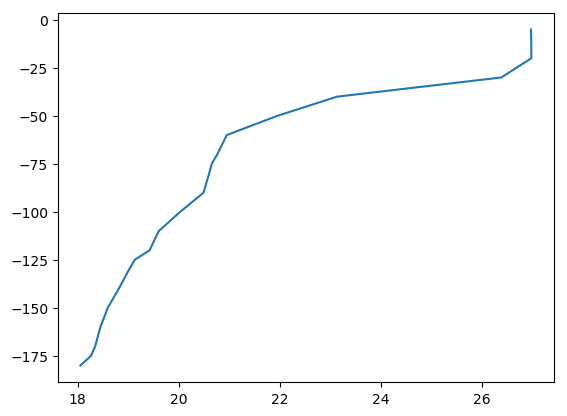

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8627cc0898>

In [22]:
figure("Australian-Data")
ax = subplot(1,1,1)
#ax.plot(temperature[:,1],-depth[:,1])
ax.plot(temperature[1:22],-depth[1:22])

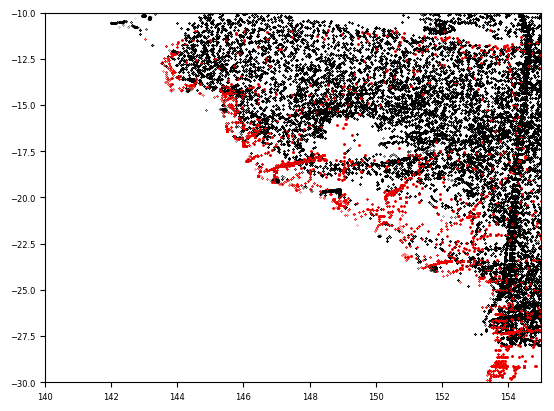

(-30, -10)

In [23]:
figure("Australian-Data")
ax = subplot(1,1,1)
plot(longitude, latitude, "ko", markersize=.1, markerfacecolor="k")
plot(longitude_ancillary, latitude_ancillary, "ro", markersize=.1, markerfacecolor="k")

aspectratio = 1/cos(mean(latr) * pi/180)
ax.tick_params("both",labelsize=6)
ax.set_xlim([140,155])
ax.set_ylim([-30,-10])

#gca().set_aspect(aspectratio)

## Run the obs checker on WOD
Basic scanner to show extents of data. usefull for identifying obvious problems 

In [24]:
checkobs((longitude,latitude,depth,time_dates),temperature,observation_id)

┌ Info: Checking ranges for dimensions and observations
└ @ DIVAnd /tube1/cha674/Anaconda_Install/miniconda/envs/julia/share/julia/packages/DIVAnd/MV3j9/src/obsstat.jl:77


              minimum and maximum of obs. dimension 1: (142.00006f0, 155.0f0)
              minimum and maximum of obs. dimension 2: (-27.99938f0, -10.0f0)
              minimum and maximum of obs. dimension 3: (0.0f0, 240.0f0)
              minimum and maximum of obs. dimension 4: (DateTime("2005-01-04T01:38:03"), DateTime("2022-12-31T05:56:14"))
                          minimum and maximum of data: (0.0010437907f0, 39.242805f0)


## Run the obs checker on the AIMS/MNF data
See above

In [25]:
checkobs((longitude_ancillary,latitude_ancillary,depth_ancillary,time_dates_ancillary),temperature,observation_id_ancillary)

              minimum and maximum of obs. dimension 1: (113.86017f0, 164.882f0)
              minimum and maximum of obs. dimension 2: (-29.86723f0, -10.717584f0)
              minimum and maximum of obs. dimension 3: (0.0f0, 238.0f0)
              minimum and maximum of obs. dimension 4: (DateTime("1899-12-30T00:00:00"), DateTime("2022-09-11T13:18:21"))
                          minimum and maximum of data: (0.0010437907f0, 39.242805f0)


┌ Info: Checking ranges for dimensions and observations
└ @ DIVAnd /tube1/cha674/Anaconda_Install/miniconda/envs/julia/share/julia/packages/DIVAnd/MV3j9/src/obsstat.jl:77


## Read the bathymetry to create the mask and bathymetric constraints

In [28]:
bathname = "/tube1/cha674/CARS_2022/cars-v2/notebooks/gebco_30sec_16.nc"
@time bx,by,b = load_bath(bathname,true,lonr,latr);

  2.474938 seconds (6.77 M allocations: 356.537 MiB, 6.76% gc time, 96.01% compilation time)


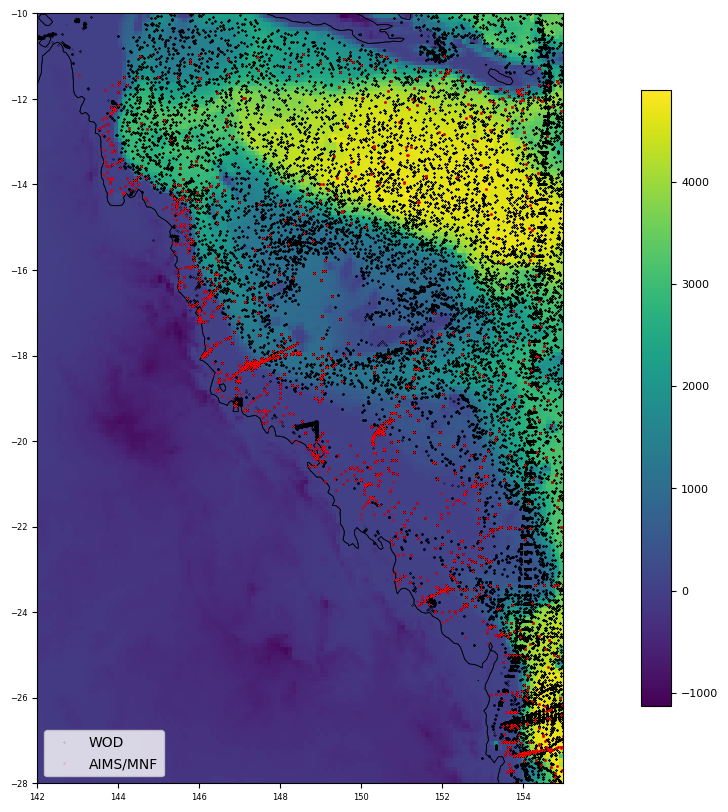

In [36]:
figure("Australian Bathymetry",figsize=(20,10))
ax = subplot(1,1,1)
pcolor(bx, by, permutedims(b, [2,1]));
colorbar(orientation="vertical", shrink=0.8).ax.tick_params(labelsize=8)
contour(bx, by, permutedims(b, [2,1]), [0, 0.1], colors="k", linewidths=.5)
plot(longitude, latitude, "ko", markersize=.1, markerfacecolor="k",label="WOD")
plot(longitude_ancillary, latitude_ancillary, "ro", markersize=.1, markerfacecolor="k",label="AIMS/MNF")
xlim([142,155])
ylim([-28,-10])
legend()
gca().set_aspect(aspectratio)
ax.tick_params("both",labelsize=6)

In [37]:
mask = falses(size(b,1),size(b,2),length(depthr))
for k = 1:length(depthr)
    for j = 1:size(b,2)
        for i = 1:size(b,1)
            mask[i,j,k] = b[i,j] >= depthr[k]
        end
    end
end
@show size(mask)

size(mask) = (131, 181, 15)


(131, 181, 15)

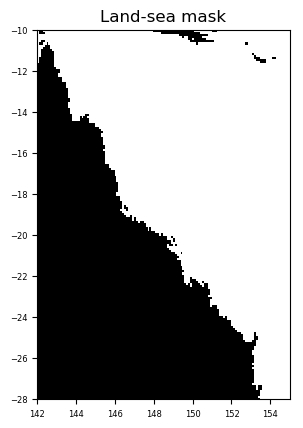

PyObject Text(0.5,1,'Land-sea mask')

In [38]:
figure("Austrlaian Mask")
ax = subplot(1,1,1)
gca().set_aspect(aspectratio)
ax.tick_params("both",labelsize=6)
ax.pcolor(bx, by, transpose(mask[:,:,1]), cmap=PyPlot.cm.binary_r)
ax.set_title("Land-sea mask")

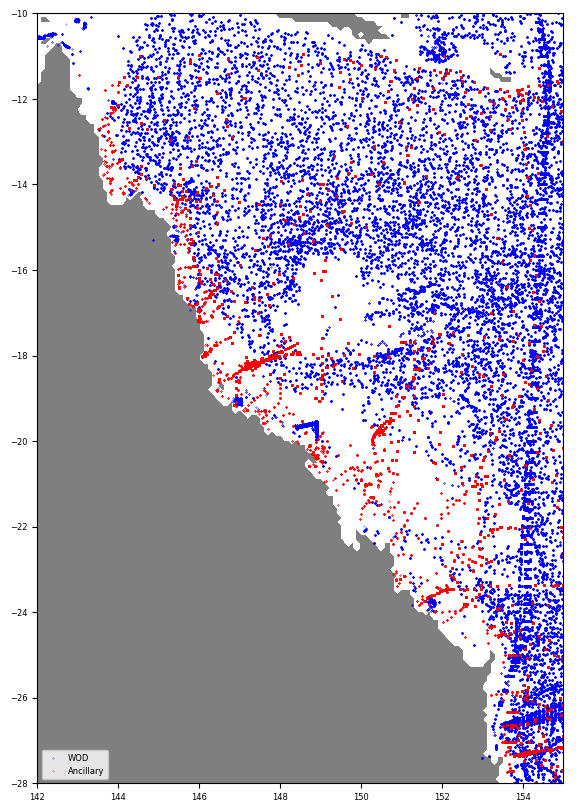

In [39]:
figure("Australia WOD",figsize=(20,10))
ax = subplot(1,1,1)
ax.tick_params("both",labelsize=6)
contourf(bx, by, permutedims(Float64.(mask[:,:,1]),[2,1]),
    levels=[-1e5,0],cmap="binary"); 
plot(longitude, latitude, "bo", markersize=.2, 
    label="WOD")
plot(longitude_ancillary, latitude_ancillary, "ro", markersize=.2, 
    label="Ancillary")

#plot(obslonwod, obslatwod, "go", markersize=.2, 
#    label="World Ocean Database");
legend(fontsize=6);
ylim(-28, -10);
xlim(142, 155);
gca().set_aspect(aspectratio)

## Check duplicates
We now check for duplicates between the WOD and ancillary datasets. Duplicates are flagged if two observations are within 0.01 degrees, 0.1m depth, 1 day and 0.01 degrees (temperatures). 

In [43]:
@time dupl = DIVAnd.Quadtrees.checkduplicates(
    (longitude,latitude,depth,time_dates), temperature,
    (longitude_ancillary,latitude_ancillary,depth_ancillary,time_dates_ancillary), temperature_ancillary,
    (0.01,0.01,0.01,1/(24*60)),0.01);


index = findall(.!isempty.(dupl));
ndupl = length(index);
pcdupl = round(ndupl / length(longitude) * 100; digits=2);
@info("Number of possible duplicates: $ndupl")
@info("Percentage of duplicates: $pcdupl%")

  2.187478 seconds (1.59 M allocations: 527.430 MiB, 5.07% gc time)


┌ Info: Number of possible duplicates: 3237
└ @ Main In[43]:10
┌ Info: Percentage of duplicates: 0.84%
└ @ Main In[43]:11


In [46]:
newpoints = isempty.(dupl);
@info("Number of new points: $(sum(newpoints)))")

longitude = [longitude; longitude_ancillary[newpoints]];
latitude = [latitude; latitude_ancillary[newpoints]];
depth = [depth; depth_ancillary[newpoints]];
time_dates = [time_dates; time_dates_ancillary[newpoints]];
temperature = [temperature; temperature_ancillary[newpoints]];


┌ Info: Number of new points: 258328)
└ @ Main In[46]:2


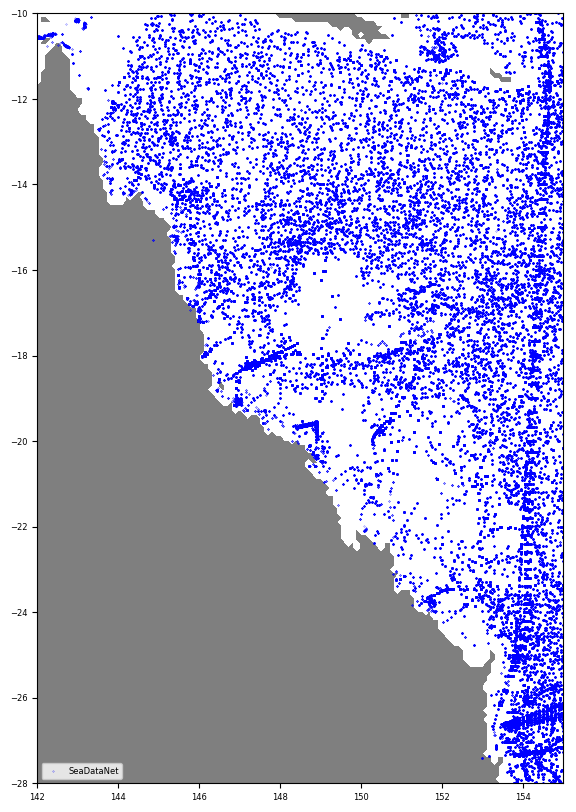

In [48]:
figure("Australia WOD",figsize=(20,10))
ax = subplot(1,1,1)
ax.tick_params("both",labelsize=6)
contourf(bx, by, permutedims(Float64.(mask[:,:,1]),[2,1]),
    levels=[-1e5,0],cmap="binary"); 
plot(longitude, latitude, "bo", markersize=.2, 
    label="SeaDataNet")
#plot(obslonwod, obslatwod, "go", markersize=.2, 
#    label="World Ocean Database");
legend(fontsize=6);
ylim(-28,-10.);
xlim(142, 155);
gca().set_aspect(aspectratio)

## Set the length scales for the interpolation

We now set the x,y and z covariance length scales for the DIVAnd software. We also specify the signal-to-noise ratio (epsilon)

In [50]:
sz = (length(lonr),length(latr),length(depthr));
lenx = fill(500_000.,sz)  # 100 km
leny = fill(250_000.,sz)   # 100 km
lenz = fill(10.,sz);      # 25 m 
len = (lenx, leny, lenz);
epsilon2 = 0.1;

Set Destination directory for the output

In [54]:
outputdir = "./Test_Data/output/"
if !isdir(outputdir)
    mkpath(outputdir)
end
filename = joinpath(outputdir, "Water_body_$(replace(varname," "=>"_"))_GBR_Real_Depth.monthly.pfl.xbt.ctd.4Danl.with_ancillary.csiro_std_lvls.lx500.ly250.nc")

"./Test_Data/output/Water_body_Temp_GBR_Real_Depth.monthly.pfl.xbt.ctd.4Danl.with_ancillary.csiro_std_lvls.lx500.ly250.nc"

Specify output meta-data

In [52]:
metadata = OrderedDict(
    # Name of the project (SeaDataCloud, SeaDataNet, EMODNET-chemistry, ...)
    "project" => "SeaDataCloud",

    # URN code for the institution EDMO registry,
    # e.g. SDN:EDMO::1579
    "institution_urn" => "SDN:EDMO::1579",

    # Production group
    #"production" => "Diva group",

    # Name and emails from authors
    "Author_e-mail" => ["Your Name1 ", "Other Name "],

    # Source of the observation
    "source" => "observational data from SeaDataNet and World Ocean Atlas",

    # Additional comment
    "comment" => "Duplicate removal applied to the merged dataset",

    # SeaDataNet Vocabulary P35 URN
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p35
    # example: SDN:P35::WATERTEMP
    "parameter_keyword_urn" => "SDN:P35::EPC00001",

    # List of SeaDataNet Parameter Discovery Vocabulary P02 URNs
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p02
    # example: ["SDN:P02::TEMP"]
    "search_keywords_urn" => ["SDN:P02::PSAL"],

    # List of SeaDataNet Vocabulary C19 area URNs
    # SeaVoX salt and fresh water body gazetteer (C19)
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=C19
    # example: ["SDN:C19::3_1"]
    "area_keywords_urn" => ["SDN:C19::3_3"],

    "product_version" => "1.0",
    
    "product_code" => "something-to-decide",
    
    # bathymetry source acknowledgement
    # see, e.g.
    # * EMODnet Bathymetry Consortium (2016): EMODnet Digital Bathymetry (DTM).
    # https://doi.org/10.12770/c7b53704-999d-4721-b1a3-04ec60c87238
    # 
    # taken from
    # http://www.emodnet-bathymetry.eu/data-products/acknowledgement-in-publications
    #
    # * The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003
    #
    # taken from
    # https://www.bodc.ac.uk/projects/data_management/international/gebco/gebco_digital_atlas/copyright_and_attribution/
        
    "bathymetry_source" => "The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003",

    # NetCDF CF standard name
    # http://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html
    # example "standard_name" = "sea_water_temperature",
    "netcdf_standard_name" => "temperature",

    "netcdf_long_name" => "temperature",

    "netcdf_units" => "1e-3",

    # Abstract for the product
    "abstract" => "...",

    # This option provides a place to acknowledge various types of support for the
    # project that produced the data
    "acknowledgement" => "...",

    "documentation" => "https://doi.org/doi_of_doc",

    # Digital Object Identifier of the data product
    "doi" => "...");


In [55]:
ncglobalattrib, ncvarattrib = SDNMetadata(metadata, filename, varname, lonr, latr)


(OrderedDict("project" => "SeaDataCloud", "institution" => "University of Liège, GeoHydrodynamics and Environment Research", "institution_urn" => "SDN:EDMO::1579", "Author_e-mail" => "Your Name1 , Other Name ", "source" => "observational data from SeaDataNet and World Ocean Atlas", "comment" => "Duplicate removal applied to the merged dataset", "parameter_keyword" => "Water body salinity", "parameter_keyword_urn" => "SDN:P35::EPC00001", "search_keywords" => "Salinity of the water column", "search_keywords_urn" => "SDN:P02::PSAL"…), OrderedDict("units" => "1e-3", "standard_name" => "temperature", "long_name" => "temperature"))

Specify the output for intermediate plots (useful for checking output as code runs

In [56]:
function plotres(timeindex,sel,fit,erri)
    tmp = copy(fit)
    nx,ny,nz = size(tmp)
    for i in 1:nz
        figure("Australian Test Real Depth with ancillary")
        ax = subplot(1,1,1)
        ax.tick_params("both",labelsize=6)
        ylim(-25, -10);
        xlim(142,155 );
        title("Depth: (timeindex)", fontsize=6)
        pcolor(lonr.-dx/2.,latr.-dy/2, permutedims(tmp[:,:,i], [2,1]);
               vmin = 25, vmax = 32)
        colorbar(extend="both", orientation="vertical", shrink=0.8).ax.tick_params(labelsize=8)

        contourf(bx,by,permutedims(b,[2,1]), levels = [-1e5,0],colors = [[.5,.5,.5]])
        aspectratio = 1/cos(mean(latr) * pi/180)
        gca().set_aspect(aspectratio)
        
        figname = varname * @sprintf("_%02d",i) * @sprintf("_%03d.png",timeindex)
        PyPlot.savefig(joinpath(figdir, figname), dpi=300, bbox_inches="tight");
        PyPlot.close_figs()
    end
end

plotres (generic function with 1 method)

In [57]:
if isfile(filename)
    rm(filename) # delete the previous analysis
    @info "Removing file $filename"
end

┌ Info: Removing file ./Test_Data/output/Water_body_Temp_GBR_Real_Depth.monthly.pfl.xbt.ctd.4Danl.with_ancillary.csiro_std_lvls.lx500.ly250.nc
└ @ Main In[57]:3


In [58]:
figdir = "./Test_Data/figures/"
if ~(isdir(figdir))
    mkdir(figdir)
else
    @info("Figure directory already exists")
end

┌ Info: Figure directory already exists
└ @ Main In[58]:5


In [ ]:
 dbinfo = diva3d((Float64.(lonr),Float64.(latr),Float64.(depthr),TS),
    (Float64.(longitude),Float64.(latitude),Float64.(depth),time_dates), Float64.(temperature),
    len, epsilon2,
    filename,varname,
    bathname=bathname,
    plotres = plotres,
    mask = mask,
    moddim = zeros(Float64,4 - 1),
    fitcorrlen = false,
    niter_e = 2,
    ncvarattrib = ncvarattrib,
    ncglobalattrib = ncglobalattrib,
    surfextend = true
    );

┌ Info: Creating netCDF file ./Test_Data/output/Water_body_Temp_GBR_Real_Depth.monthly.pfl.xbt.ctd.4Danl.with_ancillary.csiro_std_lvls.lx500.ly250.nc
└ @ DIVAnd /tube1/cha674/Anaconda_Install/miniconda/envs/julia/share/julia/packages/DIVAnd/MV3j9/src/diva.jl:374
┌ Info: Time step 1 / 12
└ @ DIVAnd /tube1/cha674/Anaconda_Install/miniconda/envs/julia/share/julia/packages/DIVAnd/MV3j9/src/diva.jl:427
┌ Info: scaled correlation length (min,max) in dimension 1: (500000.0, 500000.0)
└ @ DIVAnd /tube1/cha674/Anaconda_Install/miniconda/envs/julia/share/julia/packages/DIVAnd/MV3j9/src/diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 2: (250000.0, 250000.0)
└ @ DIVAnd /tube1/cha674/Anaconda_Install/miniconda/envs/julia/share/julia/packages/DIVAnd/MV3j9/src/diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 3: (10.0, 10.0)
└ @ DIVAnd /tube1/cha674/Anaconda_Install/miniconda/envs/julia/share/julia/packages/DIVAnd/MV3j9/src/diva.jl:612
┌ Warning: resolution (7.

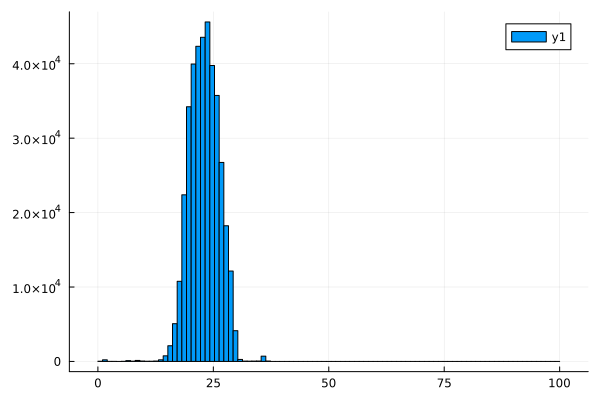

In [33]:
using Plots

histogram(temperature,bins=range(0, 100, length=100))

In [36]:
import Pkg; Pkg.add("Plots")

    Updating registry at `/tube1/cha674/Anaconda_Install/miniconda/envs/julia/share/julia/registries/General.toml`
   Resolving package versions...
   Installed Libmount_jll ───────────────── v2.35.0+0
   Installed JpegTurbo_jll ──────────────── v2.1.91+0
   Installed libfdk_aac_jll ─────────────── v2.0.2+0
   Installed x265_jll ───────────────────── v3.5.0+0
   Installed GR_jll ─────────────────────── v0.72.7+0
   Installed LERC_jll ───────────────────── v3.0.0+1
   Installed Opus_jll ───────────────────── v1.3.2+0
   Installed Xorg_xkbcomp_jll ───────────── v1.4.2+4
   Installed RelocatableFolders ─────────── v1.0.0
   Installed Grisu ──────────────────────── v1.0.2
   Installed Measures ───────────────────── v0.3.2
   Installed Unitful ────────────────────── v1.14.0
   Installed Formatting ─────────────────── v0.4.2
ERROR: Data Error : jl_jmtY3QXqNeVf1oeK~
   Installed Xorg_xcb_util_wm_jll ───────── v0.4.1+1
┌ Warning: failed to extract archive downloaded from https://pkg.julialang.